# Imports

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from typing import List, Callable, Tuple, Any
from wandb.wandb_run import Run
from datetime import datetime, timedelta
from copy import deepcopy

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, metrics, cv

import attr
import pandas as pd
import pandas_ta as pta
import gc
import os
import wandb
import nest_asyncio
import logging
import sys
import numpy as np

while "freqtrade" not in os.listdir():
    os.chdir("..")
    if "freqtrade" in os.listdir():
        nest_asyncio.apply()
        logger = logging.getLogger("freqtrade.ml")
        handler = logging.StreamHandler(stream=sys.stdout)
        handler.setFormatter(logging.Formatter("%(name)s - %(message)s"))
        logger.addHandler(handler)
        logger.setLevel(logging.INFO)

from freqtrade.ml.lightning import LightningModule, LightningConfig
from freqtrade.ml.trainer import TradingTrainer
from freqtrade.ml.container import LightningContainer
from freqtrade.ml import loader, lightning_utils
from freqtrade.optimize.optimize_reports import text_table_add_metrics
from freqtrade.nbtools.preset import ConfigPreset
from freqtrade.nbtools.backtest import backtest, DataLoader
from freqtrade.nbtools.remote_utils import load_lightning_container, get_lightning_artifact_ver
from freqtrade.nbtools.helper import parse_function_body
from freqtrade.nbtools import plotting, configs
from freqtrade.nbtools.helper import free_mem
from freqtrade.nbtools.pairs import PAIRS_HIGHCAP_NONSTABLE

# Constants
PATH_MOUNT = Path.cwd().parent / "mount"
DATALOADER = DataLoader(max_n_datasets=5)

# Custom function
def string_templating(string: str, data: dict, strip_doublequotes=False):
    _string = deepcopy(string)
    """Replace [|key|] in string with data["key"] """
    for key, value in data.items():
        to_replace = "[|{}|]".format(key)
        if strip_doublequotes:
            to_replace = "\"[|{}|]\"".format(key)
        if to_replace not in string:
            raise Exception(f"Not found formatting with key '{key}'")
        _string = _string.replace(to_replace, str(value))
    return _string


def start_backtesting(strat_func, lightning_name: str, bt_type: str, version):
    PATH_LOCAL_DATADIR = PATH_MOUNT / "data"
    LIGHTNING_CONTAINER_NAME = lightning_name

    if version == "latest":
        version = get_lightning_artifact_ver(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME)
        print(f"You are using LATEST ({version}) of '{LIGHTNING_CONTAINER_NAME}'")

    lightning_container = load_lightning_container(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME, version=version)
    
    if bt_type == "val":
        timerange = lightning_utils.get_timerange_trainval(lightning_container)
    elif bt_type == "opt":
        timerange = lightning_utils.get_timerange_opt(lightning_container)
    elif bt_type == "test":
        timerange = lightning_utils.get_timerange_test(lightning_container)
    else:
        raise Exception(f"Unknown BT type: {bt_type}")
    
    preset = ConfigPreset(
        name=f"ml_{bt_type}_{LIGHTNING_CONTAINER_NAME}",
        config_dict = configs.DEFAULT,
        path_data=PATH_LOCAL_DATADIR,
        timerange=timerange
    )
    preset.overwrite_config(pairs=lightning_container.config.pairs)

    strategy_code = string_templating(
        parse_function_body(strat_func),
        data={
            "LIGHTNING_CONTAINER_NAME": LIGHTNING_CONTAINER_NAME,
            "VERSION": version
        }
    )
    stats, summary = backtest(preset, strategy_code, dataloader=DATALOADER)
    return stats, summary, preset

# Lightning Module

In [38]:
MINI_DATA = False  
# True if used for testing purposes


attr.s(repr=False)
class CatBoostModule(LightningModule):
    """ Template for LightningModule """
        
    def on_configure(self) -> LightningConfig:
        
        # This datetime can be replaced with datetime.now()
        now = datetime(2021, 9, 1)
        
        # Lighting Configuration
        config = LightningConfig(
            
            # Basic info
            name        = "15n30-catboost_l3",
            timeframe   = "15m",
            exchange    = "binance",
            
            # Train and validation datetime
            trainval_start  = datetime(2016, 1, 1),
            trainval_end    = now - timedelta(days=91),
            
            # Backtest Optimization datetime
            opt_start = now - timedelta(days=90),
            opt_end   = now - timedelta(days=46),
            
            # Unbiased Backtest datetime
            test_start = now - timedelta(days=45),
            test_end   = now,
            
            # Optional
            num_training_epochs = 100000,
            learning_rate = 0.012,
        )
        
        # Optional custom config attributes
        config.add_custom("num_future_candles", 2)
        config.add_custom("num_classification_classes", 5)
        config.add_custom("hardware", "GPU")
        
        return config
        
    def on_get_data_paths(self, cwd: Path, timeframe: str, exchange: str) -> List[Path]:
        """ Where your data is stored
        """
        path_data_exchange = cwd.parent / "mount" / "data" / exchange
        maximum_data = 999 if not MINI_DATA else 5
        
        return [
            datapath
            for datapath in list(path_data_exchange.glob(f"*-{timeframe}.json"))
            if datapath.name.split("-")[0].replace("_", "/")
            in PAIRS_HIGHCAP_NONSTABLE[:maximum_data]
        ]
    
    def on_add_features(self, df_onepair: pd.DataFrame) -> pd.DataFrame:
        """ On Add Features will be used in inference
        """
        import pandas_ta as pta
        
        # Start add features
        spaces = [4, 6, 8, 12, 16, 26, 50, 100, 200, 300]
        
        for i in spaces:
            # Basics
            df_onepair[f"ml_smadiff_{i}"] = (df_onepair['close'].rolling(i).mean() - df_onepair['close'])
            df_onepair[f"ml_std_{i}"] = df_onepair['close'].rolling(i).std()
            df_onepair[f"ml_ma_{i}"] = df_onepair['close'].pct_change(i).rolling(i).mean()
            
            # Volume Basics
            df_onepair[f"ml_volstd_{i}"] = df_onepair['volume'].rolling(i).std()
            df_onepair[f"ml_volma_{i}"] = df_onepair['volume'].pct_change(i).rolling(i).mean()
            
            # Technical Indicators
            df_onepair.ta.rsi(length=i, append=True)
            df_onepair.ta.trix(length=i, append=True)
            # df_onepair.ta.stochrsi(length=i, append=True)
            # df_onepair.ta.macd(fast=int(i/2), slow=i, signal=9, append=True)
            # df_onepair.ta.cmo(length=i, append=True)

        for i in range(1, 30):
            # Previous Close
            df_onepair[f"ml_prevclose_{i}"] = (df_onepair["close"].shift(i) - df_onepair["close"]) / df_onepair["close"]

        for i in range(1, 11):
            # Lookback Candles
            df_onepair[f"ml_prevhigh_{i}"] = (df_onepair["high"].shift(i) - df_onepair["high"]) / df_onepair["high"]
            df_onepair[f"ml_prevlow_{i}"] = (df_onepair["low"].shift(i) - df_onepair["low"]) / df_onepair["low"]
            df_onepair[f"ml_prevopen_{i}"] = (df_onepair["open"].shift(i) - df_onepair["open"]) / df_onepair["open"]
            # Lookback Volume
            df_onepair[f"ml_prevvol_{i}"] = (df_onepair["volume"].shift(i) - df_onepair["volume"]) / df_onepair["volume"]
        
        # TODO: pct change until nearest psychological point.
        # Example: First digit change 49.000 BTC to 50.000. is 1000 (1000 / current_price ~ 0.02)
        # If closer than lower point, don't calculate to the upper point. Example: 44k is closer to 4k. BUT NEGATIVE!
            
        df_onepair["ml_volume_pctchange"] = df_onepair['volume'].pct_change()
        df_onepair['ml_z_score_120'] = (
            (df_onepair["ml_ma_16"] - df_onepair["ml_ma_16"].rolling(21).mean() + 1e-9) / 
            (df_onepair["ml_ma_16"].rolling(21).std() + 1e-9)
        )
        
        return df_onepair
    
    def on_add_labels(self, df_onepair: pd.DataFrame) -> pd.DataFrame:
        """ Define the labels
        """
        future_price = df_onepair['close'].shift(-self.config.num_future_candles)
        ml_label = (future_price - df_onepair['close']) / df_onepair['close']
        df_onepair[self.config.column_y] = pd.qcut(ml_label, self.config.num_classification_classes, labels=False)
        return df_onepair
    
    def on_final_processing(self, df_allpairs: pd.DataFrame) -> Tuple[Any, Any, Any, Any]:
        """ Define the data to X_train, X_val, y_train, y_val
        """
        # val_split_date = pd.to_datetime(self.config.trainval_end - timedelta(days=60), utc=True, infer_datetime_format=True)
        
        # train = df_allpairs[df_allpairs["date"] < val_split_date]
        # val = df_allpairs[df_allpairs["date"] >= val_split_date]

        # print("Train start - end:", train["date"].min(), train["date"].max())
        # print("Val start - end:", val["date"].min(), val["date"].max())

        # X_train = train[self.config.columns_x]
        # X_val = val[self.config.columns_x]
        # y_train = train[self.config.column_y]
        # y_val = val[self.config.column_y]

        X = df_allpairs[self.config.columns_x]
        y = df_allpairs[self.config.column_y]
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
    
        print("Num train datas:", len(X_train))
        print("Num val datas:", len(X_val))

        return X_train, X_val, y_train, y_val
    
    def on_define_model(self, run: Run, X_train, X_val, y_train, y_val) -> Any:
        """ Define your model!
        """
        return CatBoostClassifier(
            custom_loss=[metrics.Accuracy()],
            iterations=self.config.num_training_epochs, 
            task_type=self.config.hardware,
            learning_rate=self.config.learning_rate,
         )
    
    def on_start_training(self, run: Run, X_train, X_val, y_train, y_val):
        """ Training / model fit code
        """
        print("Start Training...")
        self.model: CatBoostClassifier
        self.model.fit(
            X_train, y_train,
            eval_set=(X_val, y_val),
            plot=True,
            verbose=1000,
        )
        print("Accuracy: %.4f" % self.model.score(X_val, y_val))
    
    def on_predict(self, df_input_onepair: pd.DataFrame) -> pd.DataFrame:
        """ Inference, used in freqtrade
        """
        df_input_np = df_input_onepair.to_numpy()
        preds = self.model.predict_proba(df_input_np)
        return pd.DataFrame(preds)
    
    def on_training_step(self, run: Run, data: dict):
        raise NotImplementedError()


module = CatBoostModule()
container = LightningContainer(module)

freqtrade.ml.container - Set up config


INFO:freqtrade.ml.container:Set up config


freqtrade.ml.container - {'name': '15n30-catboost_l3', 'timeframe': '15m', 'exchange': 'binance', 'trainval_start': datetime.datetime(2016, 1, 1, 0, 0), 'trainval_end': datetime.datetime(2021, 6, 2, 0, 0), 'opt_start': datetime.datetime(2021, 6, 3, 0, 0), 'opt_end': datetime.datetime(2021, 7, 17, 0, 0), 'test_start': datetime.datetime(2021, 7, 18, 0, 0), 'test_end': datetime.datetime(2021, 9, 1, 0, 0), 'num_training_epochs': 100000, 'learning_rate': 0.012, 'column_y': 'ml_label', 'columns_unused': ['date', 'open', 'high', 'low', 'close', 'volume', 'pair', 'ml_label'], 'columns_x': None, 'data_filenames': ['AAVE_USDT-15m.json', 'ADA_USDT-15m.json', 'ALGO_USDT-15m.json', 'ANKR_USDT-15m.json', 'ATOM_USDT-15m.json', 'AVAX_USDT-15m.json', 'BAT_USDT-15m.json', 'BCH_USDT-15m.json', 'BNT_USDT-15m.json', 'BTC_USDT-15m.json', 'BTT_USDT-15m.json', 'CHZ_USDT-15m.json', 'COMP_USDT-15m.json', 'CRV_USDT-15m.json', 'DASH_USDT-15m.json', 'DCR_USDT-15m.json', 'DOGE_USDT-15m.json', 'DOT_USDT-15m.json', '

INFO:freqtrade.ml.container:{'name': '15n30-catboost_l3', 'timeframe': '15m', 'exchange': 'binance', 'trainval_start': datetime.datetime(2016, 1, 1, 0, 0), 'trainval_end': datetime.datetime(2021, 6, 2, 0, 0), 'opt_start': datetime.datetime(2021, 6, 3, 0, 0), 'opt_end': datetime.datetime(2021, 7, 17, 0, 0), 'test_start': datetime.datetime(2021, 7, 18, 0, 0), 'test_end': datetime.datetime(2021, 9, 1, 0, 0), 'num_training_epochs': 100000, 'learning_rate': 0.012, 'column_y': 'ml_label', 'columns_unused': ['date', 'open', 'high', 'low', 'close', 'volume', 'pair', 'ml_label'], 'columns_x': None, 'data_filenames': ['AAVE_USDT-15m.json', 'ADA_USDT-15m.json', 'ALGO_USDT-15m.json', 'ANKR_USDT-15m.json', 'ATOM_USDT-15m.json', 'AVAX_USDT-15m.json', 'BAT_USDT-15m.json', 'BCH_USDT-15m.json', 'BNT_USDT-15m.json', 'BTC_USDT-15m.json', 'BTT_USDT-15m.json', 'CHZ_USDT-15m.json', 'COMP_USDT-15m.json', 'CRV_USDT-15m.json', 'DASH_USDT-15m.json', 'DCR_USDT-15m.json', 'DOGE_USDT-15m.json', 'DOT_USDT-15m.json'

# Dataset EDA Before Training

In [4]:
df_: pd.DataFrame = lightning_utils.get_dataset_df(container)
X_train, X_val, y_train, y_val = container.final_processing(df_)
dates = df_["date"]
df_ = df_[module.config.columns_x + [module.config.column_y]]
df_.tail()

Load and preprocess data:   0%|          | 0/61 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [45]:
print(list(df_.columns))
print(f"Total features: {len(list(df_.columns))}")

['ml_smadiff_4', 'ml_std_4', 'ml_ma_4', 'ml_volstd_4', 'ml_volma_4', 'MACD_2_4_9', 'MACDh_2_4_9', 'MACDs_2_4_9', 'RSI_4', 'CMO_4', 'STOCHRSIk_4_14_3_3', 'STOCHRSId_4_14_3_3', 'TRIX_4_9', 'TRIXs_4_9', 'ml_smadiff_6', 'ml_std_6', 'ml_ma_6', 'ml_volstd_6', 'ml_volma_6', 'MACD_3_6_9', 'MACDh_3_6_9', 'MACDs_3_6_9', 'RSI_6', 'CMO_6', 'STOCHRSIk_6_14_3_3', 'STOCHRSId_6_14_3_3', 'TRIX_6_9', 'TRIXs_6_9', 'ml_smadiff_8', 'ml_std_8', 'ml_ma_8', 'ml_volstd_8', 'ml_volma_8', 'MACD_4_8_9', 'MACDh_4_8_9', 'MACDs_4_8_9', 'RSI_8', 'CMO_8', 'STOCHRSIk_8_14_3_3', 'STOCHRSId_8_14_3_3', 'TRIX_8_9', 'TRIXs_8_9', 'ml_smadiff_12', 'ml_std_12', 'ml_ma_12', 'ml_volstd_12', 'ml_volma_12', 'MACD_6_12_9', 'MACDh_6_12_9', 'MACDs_6_12_9', 'RSI_12', 'CMO_12', 'STOCHRSIk_12_14_3_3', 'STOCHRSId_12_14_3_3', 'TRIX_12_9', 'TRIXs_12_9', 'ml_smadiff_16', 'ml_std_16', 'ml_ma_16', 'ml_volstd_16', 'ml_volma_16', 'MACD_8_16_9', 'MACDh_8_16_9', 'MACDs_8_16_9', 'RSI_16', 'CMO_16', 'STOCHRSIk_16_14_3_3', 'STOCHRSId_16_14_3_3', 'TR

In [46]:
def dataframe_statistics(df_: pd.DataFrame):
    # Detect nan, infinity, and too large values in dataset
    print("N rows na:", str(df_.shape[0] - df_.dropna().shape[0]))
    print("N rows inf:", str(df_.shape[0] - df_.replace([np.inf, -np.inf], np.nan).dropna().shape[0]))
    print("Cols na:", str(df_.columns[df_.isna().any()].tolist()))
    print("Cols inf:", str(list(df_.columns.to_series()[np.isinf(df_).any()])))

    # Detect columns with irregular datatypes
    supported_datatypes = ["float32"]
    print("Irregular (col, dtypes):", str([(it, df_[it].dtype) for it in df_.columns if df_[it].dtype not in supported_datatypes]))

    # Dataset statistics
    print("Dataset Length: %s" % len(df_))
    print("Date Min: %s" % dates.min())
    print("Date Max: %s" % dates.max())
    
dataframe_statistics(df_)

N rows na: 0
N rows inf: 0
Cols na: []
Cols inf: []
Irregular (col, dtypes): []
Dataset Length: 491793
Date Min: 2017-08-26 09:45:00+00:00
Date Max: 2021-06-01 23:30:00+00:00


<AxesSubplot:>

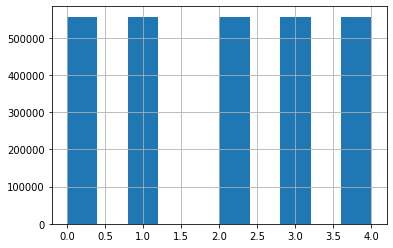

In [16]:
df_["ml_label"].hist()

In [18]:
# Unload dataset after EDA to save memory
free_mem(df_)

# [-Start Training-]

In [39]:
with wandb.init(project=module.config.name) as run:
    trainer = TradingTrainer()
    container = trainer.fit(module, run, True)

freqtrade.ml.container - Set up config


INFO:freqtrade.ml.container:Set up config


freqtrade.ml.container - {'name': '15n30-catboost_l3', 'timeframe': '15m', 'exchange': 'binance', 'trainval_start': datetime.datetime(2016, 1, 1, 0, 0), 'trainval_end': datetime.datetime(2021, 6, 2, 0, 0), 'opt_start': datetime.datetime(2021, 6, 3, 0, 0), 'opt_end': datetime.datetime(2021, 7, 17, 0, 0), 'test_start': datetime.datetime(2021, 7, 18, 0, 0), 'test_end': datetime.datetime(2021, 9, 1, 0, 0), 'num_training_epochs': 100000, 'learning_rate': 0.012, 'column_y': 'ml_label', 'columns_unused': ['date', 'open', 'high', 'low', 'close', 'volume', 'pair', 'ml_label'], 'columns_x': None, 'data_filenames': ['AAVE_USDT-15m.json', 'ADA_USDT-15m.json', 'ALGO_USDT-15m.json', 'ANKR_USDT-15m.json', 'ATOM_USDT-15m.json', 'AVAX_USDT-15m.json', 'BAT_USDT-15m.json', 'BCH_USDT-15m.json', 'BNT_USDT-15m.json', 'BTC_USDT-15m.json', 'BTT_USDT-15m.json', 'CHZ_USDT-15m.json', 'COMP_USDT-15m.json', 'CRV_USDT-15m.json', 'DASH_USDT-15m.json', 'DCR_USDT-15m.json', 'DOGE_USDT-15m.json', 'DOT_USDT-15m.json', '

INFO:freqtrade.ml.container:{'name': '15n30-catboost_l3', 'timeframe': '15m', 'exchange': 'binance', 'trainval_start': datetime.datetime(2016, 1, 1, 0, 0), 'trainval_end': datetime.datetime(2021, 6, 2, 0, 0), 'opt_start': datetime.datetime(2021, 6, 3, 0, 0), 'opt_end': datetime.datetime(2021, 7, 17, 0, 0), 'test_start': datetime.datetime(2021, 7, 18, 0, 0), 'test_end': datetime.datetime(2021, 9, 1, 0, 0), 'num_training_epochs': 100000, 'learning_rate': 0.012, 'column_y': 'ml_label', 'columns_unused': ['date', 'open', 'high', 'low', 'close', 'volume', 'pair', 'ml_label'], 'columns_x': None, 'data_filenames': ['AAVE_USDT-15m.json', 'ADA_USDT-15m.json', 'ALGO_USDT-15m.json', 'ANKR_USDT-15m.json', 'ATOM_USDT-15m.json', 'AVAX_USDT-15m.json', 'BAT_USDT-15m.json', 'BCH_USDT-15m.json', 'BNT_USDT-15m.json', 'BTC_USDT-15m.json', 'BTT_USDT-15m.json', 'CHZ_USDT-15m.json', 'COMP_USDT-15m.json', 'CRV_USDT-15m.json', 'DASH_USDT-15m.json', 'DCR_USDT-15m.json', 'DOGE_USDT-15m.json', 'DOT_USDT-15m.json'

freqtrade.ml.trainer - Validating model using mini training...


INFO:freqtrade.ml.trainer:Validating model using mini training...


Load and preprocess data:   0%|          | 0/1 [00:00<?, ?it/s]

Num train datas: 89148
Num val datas: 22288
Start Training...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.6073408	test: 1.6073895	best: 1.6073895 (0)	total: 17.1ms	remaining: 154ms
9:	learn: 1.5902737	test: 1.5908401	best: 1.5908401 (9)	total: 158ms	remaining: 0us
bestTest = 1.590840117
bestIteration = 9
Accuracy: 0.3118


C:\Users\User\AppData\Local\Temp/ipykernel_35928/2535574647.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_onepair[f"ml_prevclose_{i}"] = (df_onepair["close"].shift(i) - df_onepair["close"]) / df_onepair["close"]
C:\Users\User\AppData\Local\Temp/ipykernel_35928/2535574647.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_onepair[f"ml_prevhigh_{i}"] = (df_onepair["high"].shift(i) - df_onepair["high"]) / df_onepair["high"]
C:\Users\User\AppData\Local\Temp/ipykernel_35928/2535574647.py:91: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame


PASSED: The model passed the validation test!
freqtrade.ml.trainer - Validate model OK!


INFO:freqtrade.ml.trainer:Validate model OK!


Load and preprocess data:   0%|          | 0/61 [00:00<?, ?it/s]

Num train datas: 2197845
Num val datas: 549462


C:\Users\User\AppData\Local\Temp/ipykernel_35928/2535574647.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_onepair[f"ml_prevclose_{i}"] = (df_onepair["close"].shift(i) - df_onepair["close"]) / df_onepair["close"]
C:\Users\User\AppData\Local\Temp/ipykernel_35928/2535574647.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_onepair[f"ml_prevhigh_{i}"] = (df_onepair["high"].shift(i) - df_onepair["high"]) / df_onepair["high"]
C:\Users\User\AppData\Local\Temp/ipykernel_35928/2535574647.py:91: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame

Start Training...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.6083702	test: 1.6083535	best: 1.6083535 (0)	total: 59.7ms	remaining: 1h 39m 30s
1000:	learn: 1.5238652	test: 1.5255615	best: 1.5255615 (1000)	total: 1m	remaining: 1h 40m 4s
2000:	learn: 1.5176507	test: 1.5209987	best: 1.5209987 (2000)	total: 2m 2s	remaining: 1h 39m 55s
3000:	learn: 1.5133120	test: 1.5182242	best: 1.5182242 (3000)	total: 3m 4s	remaining: 1h 39m 12s
4000:	learn: 1.5097105	test: 1.5161557	best: 1.5161557 (4000)	total: 4m 5s	remaining: 1h 38m 20s
5000:	learn: 1.5065845	test: 1.5145157	best: 1.5145157 (5000)	total: 5m 7s	remaining: 1h 37m 29s
6000:	learn: 1.5037443	test: 1.5131286	best: 1.5131286 (6000)	total: 6m 8s	remaining: 1h 36m 16s
7000:	learn: 1.5010737	test: 1.5119269	best: 1.5119269 (7000)	total: 7m 10s	remaining: 1h 35m 15s
8000:	learn: 1.4986113	test: 1.5108806	best: 1.5108806 (8000)	total: 8m 12s	remaining: 1h 34m 23s
9000:	learn: 1.4962388	test: 1.5099447	best: 1.5099447 (9000)	total: 9m 13s	remaining: 1h 33m 18s
10000:	learn: 1.4939453	test: 1.5090

# Predictions EDA

In [11]:
# Validate prediction function by simulate inserting freqtrade data into predict function
df_val_preds = trainer.validate_predict(container)
df_val_preds

freqtrade.ml.container - Not dropping X columns in predict because it doesn't exist in predict columns


INFO:freqtrade.ml.container:Not dropping X columns in predict because it doesn't exist in predict columns


freqtrade.ml.container - Returned new columns from df_preds: ['ml_0', 'ml_1', 'ml_2', 'ml_3', 'ml_4']


INFO:freqtrade.ml.container:Returned new columns from df_preds: ['ml_0', 'ml_1', 'ml_2', 'ml_3', 'ml_4']



Dataset: Binance BTC/USDT 15m iloc[-10000:] (Freqtrade Regularized)


DF WITH PREDICTIONS INFO
----------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 131026 to 141025
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   date    10000 non-null  datetime64[ns, UTC]
 1   open    10000 non-null  float64            
 2   high    10000 non-null  float64            
 3   low     10000 non-null  float64            
 4   close   10000 non-null  float64            
 5   volume  10000 non-null  float64            
 6   ml_0    9185 non-null   float64            
 7   ml_1    9185 non-null   float64            
 8   ml_2    9185 non-null   float64            
 9   ml_3    9185 non-null   float64            
 10  ml_4    9185 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(10)
memory usage: 937.5 KB
None


DF Original
----------
                            date      open  

,date,open,high,low,close,volume,ml_0,ml_1,ml_2,ml_3,ml_4
131026,2021-05-13 00:30:00+00:00,49711.83,50630.00,49578.94,49896.61,5110.913916,NaN,NaN,NaN,NaN,NaN
131027,2021-05-13 00:45:00+00:00,49896.15,50324.72,49581.44,49666.99,2389.969100,NaN,NaN,NaN,NaN,NaN
131028,2021-05-13 01:00:00+00:00,49661.12,50600.00,49305.43,50191.47,3869.211034,NaN,NaN,NaN,NaN,NaN
131029,2021-05-13 01:15:00+00:00,50191.47,50437.86,49972.44,50324.12,2755.398561,NaN,NaN,NaN,NaN,NaN
131030,2021-05-13 01:30:00+00:00,50314.99,50374.48,49665.94,49889.82,2116.566505,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
141021,2021-08-25 03:15:00+00:00,48135.89,48274.85,48117.73,48250.65,211.447645,0.201529,0.255884,0.202371,0.166218,0.173998
141022,2021-08-25 03:30:00+00:00,48250.65,48275.00,48132.05,48191.09,194.839454,0.186121,0.231312,0.211827,0.196422,0.174319
141023,2021-08-25 03:45:00+00:00,48191.08,48248.23,47965.00,47975.93,344.786940,0.237812,0.162050,0.153346,0.197669,0.249123
141024,2021-08-25 04:00:00+00:00,47975.93,48245.00,47940.02,48155.56,275.930495,0.233152,0.200926,0.174560,0.174439,0.216924


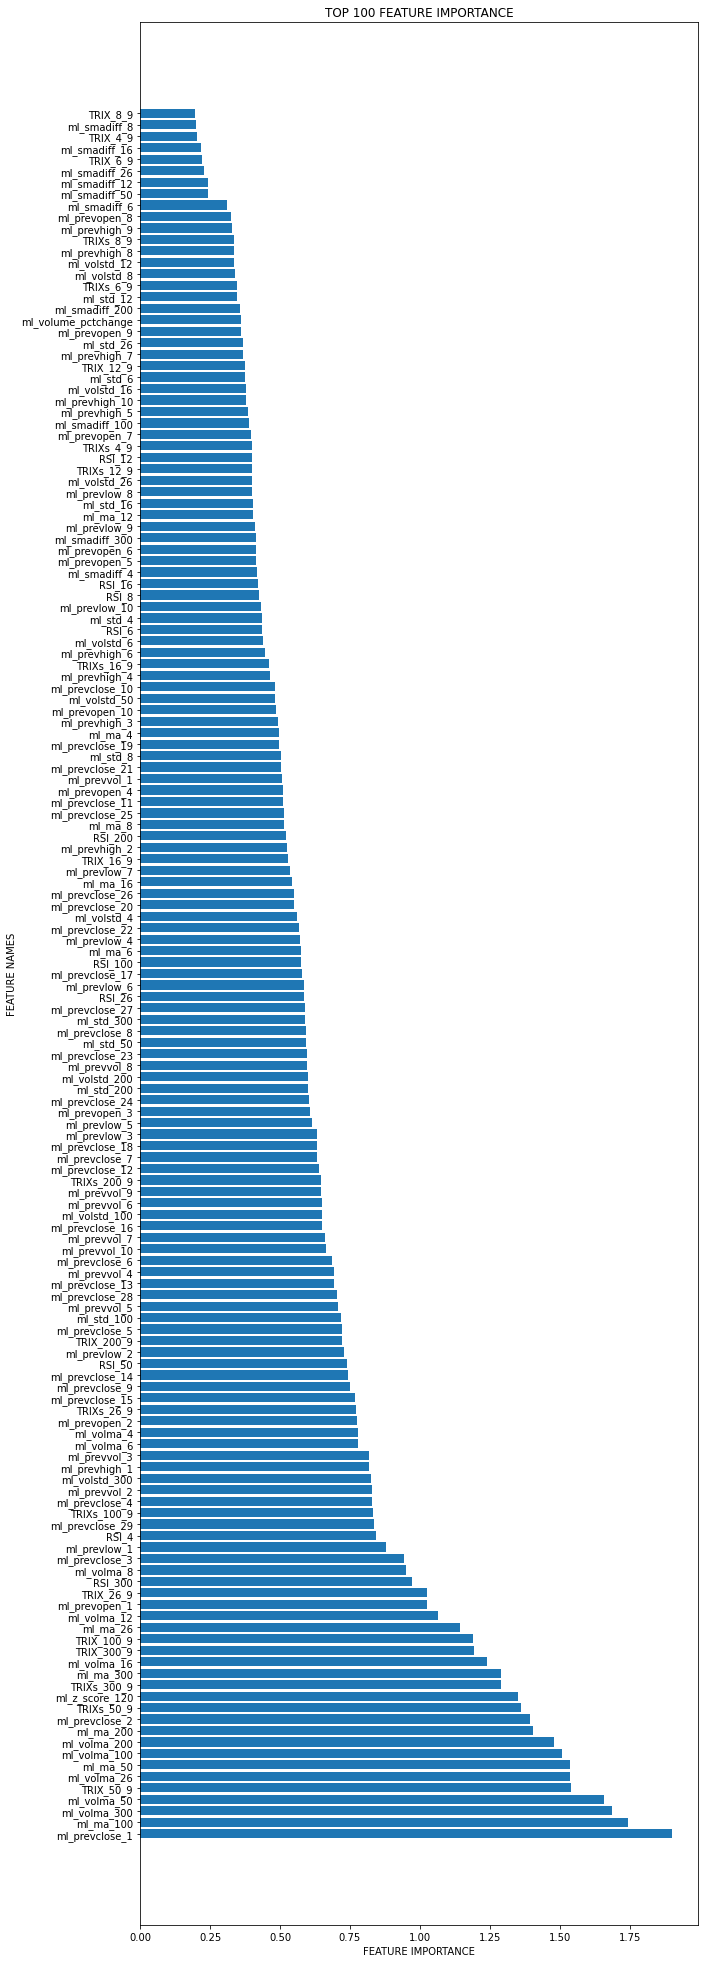

In [40]:
def plot_feature_importance(importance,names,model_type):
    import matplotlib.pyplot as plt
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,35))
    #Plot Searborn bar chart
    plt.barh(width=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
plot_feature_importance(container.module.model.get_feature_importance(), container.config.columns_x, 'TOP 100')

In [16]:
# TODO: Implement "container.get_sample_predictions()" that returns df in trainval data
df_val_preds["next"] = (df_val_preds["close"].shift(container.config.num_future_candles) / df_val_preds["close"]) - 1
df_val_preds["argmax_ml"] = df_val_preds[[f"ml_{x}"for x in range(5)]].idxmax(axis=1)
df_val_preds.loc[df_val_preds["argmax_ml"] == "ml_4"]

,date,open,high,low,close,volume,ml_0,ml_1,ml_2,ml_3,ml_4,next,argmax_ml
131425,2021-05-17 04:15:00+00:00,43147.31,43800.00,42700.93,43553.95,3136.411829,0.358041,0.073891,0.054471,0.072139,0.441457,-0.014660,ml_4
131426,2021-05-17 04:30:00+00:00,43553.83,44300.00,43120.12,43138.95,2543.326712,0.320938,0.059769,0.040835,0.058119,0.520339,0.000194,ml_4
131428,2021-05-17 05:00:00+00:00,43582.60,43800.00,43229.12,43295.15,1762.700218,0.369821,0.067685,0.042813,0.060086,0.459594,-0.003608,ml_4
131429,2021-05-17 05:15:00+00:00,43295.15,43369.81,42856.92,42940.97,2151.894111,0.341592,0.058220,0.037627,0.054436,0.508125,0.014941,ml_4
131430,2021-05-17 05:30:00+00:00,42940.97,43324.19,42500.00,42646.57,2191.744143,0.351220,0.054917,0.037836,0.054672,0.501355,0.015208,ml_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
141013,2021-08-25 01:15:00+00:00,47813.26,47908.69,47739.45,47823.60,367.466489,0.246611,0.163032,0.142366,0.180546,0.267446,0.003853,ml_4
141014,2021-08-25 01:30:00+00:00,47823.59,48035.98,47793.27,48029.74,274.782834,0.229451,0.210536,0.169417,0.158780,0.231816,-0.004507,ml_4
141017,2021-08-25 02:15:00+00:00,48208.51,48208.51,48033.27,48100.01,276.441309,0.221751,0.205182,0.170183,0.181094,0.221790,0.001168,ml_4
141023,2021-08-25 03:45:00+00:00,48191.08,48248.23,47965.00,47975.93,344.786940,0.237812,0.162050,0.153346,0.197669,0.249123,0.005726,ml_4


# Backtesting: Model Validation

In [7]:
MODEL_NAME = "15n30-catboost_l3"
MODEL_VER = "v6"  # Max ver: v6
fullname = MODEL_NAME + ":" + MODEL_VER

INFO:freqtrade.nbtools.preset.base_preset:Overwriting pairs (from 0 to 61 pairs)
INFO:freqtrade.nbtools.preset.base_preset:Overwriting pairs (from 0 to 61 pairs)
INFO:freqtrade.nbtools.preset.base_preset:Setting config for ml_val_15n30-catboost_l3 ...
INFO:freqtrade.nbtools.preset.base_preset:Setting arg `datadir` to c:\CS\Python\crypto-collection\freqtrade\mount\data\binance
INFO:freqtrade.nbtools.preset.base_preset:Setting arg `timerange` to 20160101-20210602
INFO:freqtrade.loggers:Verbosity set to 0
INFO:freqtrade.configuration.configuration:Using max_open_trades: 6 ...
INFO:freqtrade.configuration.configuration:Parameter --timerange detected: 20160101-20210602 ...
INFO:freqtrade.configuration.configuration:Using user-data directory: c:\CS\Python\crypto-collection\freqtrade\superft\user_data ...
INFO:freqtrade.configuration.configuration:Using data directory: c:\CS\Python\crypto-collection\freqtrade\mount\data\binance ...
INFO:freqtrade.configuration.check_exchange:Checking exchange

Populating Indicators:   0%|          | 0/61 [00:00<?, ?it/s]

C:\Users\User\AppData\Local\Temp/ipykernel_35928/1705978622.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_onepair[f"ml_prevclose_{i}"] = (df_onepair["close"].shift(i) - df_onepair["close"]) / df_onepair["close"]
C:\Users\User\AppData\Local\Temp/ipykernel_35928/1705978622.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_onepair[f"ml_prevhigh_{i}"] = (df_onepair["high"].shift(i) - df_onepair["high"]) / df_onepair["high"]
C:\Users\User\AppData\Local\Temp/ipykernel_35928/1705978622.py:91: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame

Preset Name: ml_val_15n30-catboost_l3__backtest-2021-09-05_17-05-34


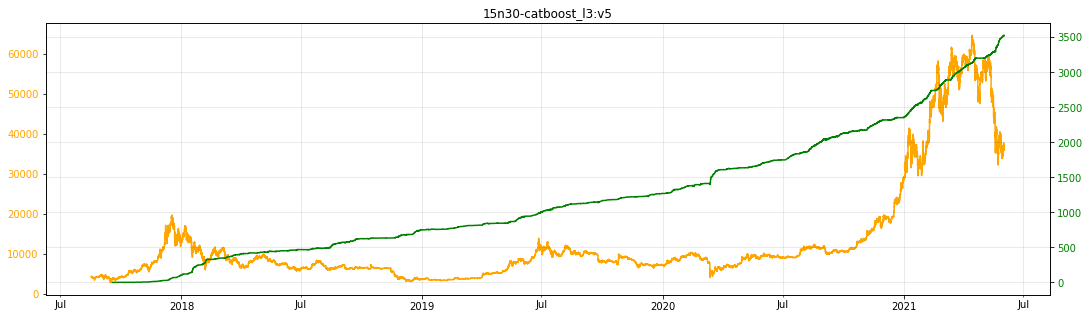

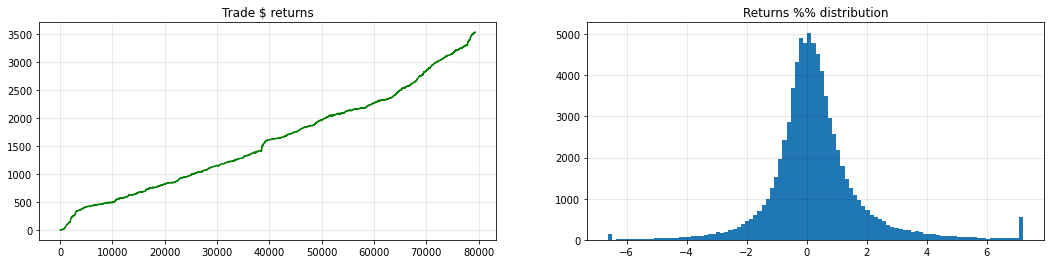

,Portfolio Summary
Trades,79364
Avg. Stake Amount,15.0
Number of Pairs,61
Min Balance,-0.03
Max Balance,3527.55
Final Balance,3527.02
-,-
Wins,45062
Loses,34302
Win Rate,56.78%


INFO:freqtrade.nbtools.backtest:===============================
INFO:freqtrade.nbtools.backtest:|  'ml_val_15n30-catboost_l3__backtest-2021-09-05_17-05-34'
INFO:freqtrade.nbtools.backtest:|  WANDB LOG PRESET FINISHED  
INFO:freqtrade.nbtools.backtest:===============================


In [41]:
"""
This strategy will backtested in Train and Validation date.
To make sure the model was fitted correctly, you need to know that you model is predicting accurately in this date.
Create the strategy that BUYS when the ML Model predicts the future is going to UP, and do the same for the sell.
The strategy doesn't need to be trend following, but the final backtest results must profitable steadily.
"""

def val_strategy():
    """ Start Strategy Code """
    from freqtrade.nbtools.strategy import INbStrategy
    from freqtrade.nbtools.remote_utils import load_lightning_container
    from freqtrade.ml.container import LightningContainer
    from pandas import DataFrame
    from functools import reduce
    import numpy as np  # noqa
    import pandas as pd  # noqa
    import talib.abstract as ta
    
    LIGHTNING_CONTAINER_NAME = "[|LIGHTNING_CONTAINER_NAME|]"
    lightning_container = load_lightning_container(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME, version="[|VERSION|]")        
    tp = str(int(lightning_container.config.timeframe.replace("m", "")) * lightning_container.config.num_future_candles)

    class NotebookStrategy(INbStrategy):
        # These attributes are REQUIRED!
        timeframe = lightning_container.config.timeframe
        minimal_roi = {tp: -1}
        stoploss = -999
        startup_candle_count: int = 500
                    
        def populate_indicators(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            dataframe = lightning_container.predict(dataframe)
            num_classes = lightning_container.config.num_classification_classes
            dataframe["argmax_ml"] = dataframe[[f"ml_{x}"for x in range(num_classes)]].idxmax(axis=1)
            return dataframe

        def populate_buy_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            conditions = [
                dataframe["argmax_ml"] == "ml_4",
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'buy'] = 1
                        
            return dataframe

        def populate_sell_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            num_candles_forward = lightning_container.config.num_future_candles
            conditions = [
                dataframe['buy'].shift(num_candles_forward) == 1,
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'sell'] = 1

            return dataframe
    """ End Strategy Code """

stats, summary, preset = start_backtesting(val_strategy, MODEL_NAME, "val", version=MODEL_VER)
trades = pd.DataFrame(stats["strategy"]["NotebookStrategy"]["trades"])
plotting.plot_profits_timerange(trades, timerange=preset.timerange, path_mount=PATH_MOUNT, name=fullname)

# Backtesting: Strategy Optimization

INFO:freqtrade.nbtools.preset.base_preset:Overwriting pairs (from 0 to 61 pairs)
INFO:freqtrade.nbtools.preset.base_preset:Overwriting pairs (from 0 to 61 pairs)
INFO:freqtrade.nbtools.preset.base_preset:Setting config for ml_opt_15n30-catboost_l3 ...
INFO:freqtrade.nbtools.preset.base_preset:Setting arg `datadir` to c:\CS\Python\crypto-collection\freqtrade\mount\data\binance
INFO:freqtrade.nbtools.preset.base_preset:Setting arg `timerange` to 20210603-20210717
INFO:freqtrade.loggers:Verbosity set to 0
INFO:freqtrade.configuration.configuration:Using max_open_trades: 6 ...
INFO:freqtrade.configuration.configuration:Parameter --timerange detected: 20210603-20210717 ...
INFO:freqtrade.configuration.configuration:Using user-data directory: c:\CS\Python\crypto-collection\freqtrade\superft\user_data ...
INFO:freqtrade.configuration.configuration:Using data directory: c:\CS\Python\crypto-collection\freqtrade\mount\data\binance ...
INFO:freqtrade.configuration.check_exchange:Checking exchange

Populating Indicators:   0%|          | 0/61 [00:00<?, ?it/s]

C:\Users\User\AppData\Local\Temp/ipykernel_35928/1705978622.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_onepair[f"ml_prevclose_{i}"] = (df_onepair["close"].shift(i) - df_onepair["close"]) / df_onepair["close"]
C:\Users\User\AppData\Local\Temp/ipykernel_35928/1705978622.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_onepair[f"ml_prevhigh_{i}"] = (df_onepair["high"].shift(i) - df_onepair["high"]) / df_onepair["high"]
C:\Users\User\AppData\Local\Temp/ipykernel_35928/1705978622.py:91: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame

Preset Name: ml_opt_15n30-catboost_l3__backtest-2021-09-05_17-13-30


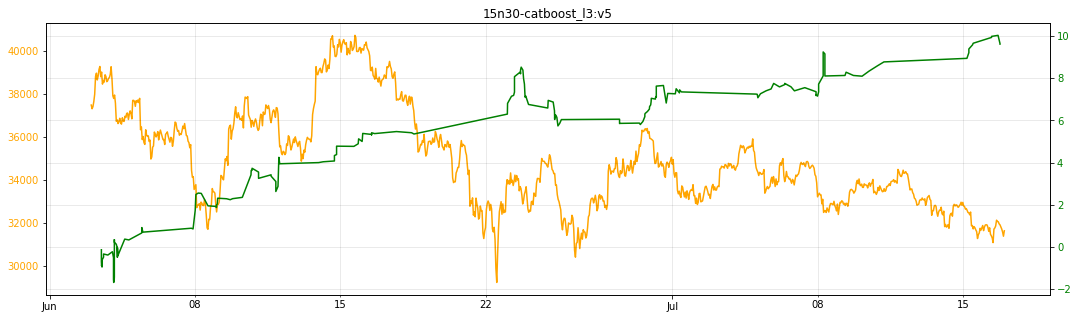

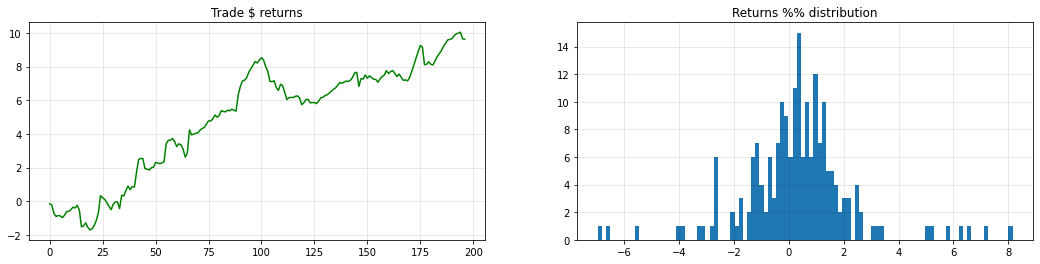

,Portfolio Summary
Trades,197
Avg. Stake Amount,15.0
Number of Pairs,43
Min Balance,-1.7
Max Balance,10.04
Final Balance,9.62
-,-
Wins,121
Loses,76
Win Rate,61.42%


In [50]:
"""
Phase where you can trial and error, plug and play model with any strategy, until get the best results.
In this phase, feel free to combine the trained model with a variety of technical indicators or ensemble with another model.

TIP: High threshold no trendline |OR| Low threshold with trendline
"""

def opt_strategy():
    """ Start Strategy Code """
    from freqtrade.nbtools.strategy import INbStrategy
    from freqtrade.nbtools.remote_utils import load_lightning_container
    from freqtrade.ml.container import LightningContainer
    from pandas import DataFrame
    from functools import reduce
    import freqtrade.vendor.qtpylib.indicators as qtpylib
    import numpy as np  # noqa
    import pandas as pd  # noqa
    import talib.abstract as ta
    import pandas_ta as pta
    
    LIGHTNING_CONTAINER_NAME = "[|LIGHTNING_CONTAINER_NAME|]"
    lightning_container = load_lightning_container(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME, version="[|VERSION|]")        
    tp = str(int(lightning_container.config.timeframe.replace("m", "")) * lightning_container.config.num_future_candles)
    
    class NotebookStrategy(INbStrategy):
        # These attributes are REQUIRED!
        timeframe = lightning_container.config.timeframe
        minimal_roi = {tp: -1}
        stoploss = -0.99
        startup_candle_count: int = 500
        
        def populate_indicators(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            dataframe["ema_fast"] = ta.EMA(dataframe, timeperiod=5)
            dataframe["ema_slow"] = ta.EMA(dataframe, timeperiod=30)
            dataframe["ema_trend"] = ta.EMA(dataframe, timeperiod=200)
            dataframe["ema_volume"] = ta.EMA(dataframe["volume"], timeperiod=50)
            
            dataframe = lightning_container.predict(dataframe)
            num_classes = lightning_container.config.num_classification_classes
            dataframe["argmax_ml"] = dataframe[[f"ml_{x}"for x in range(num_classes)]].idxmax(axis=1)
            
            return dataframe

        def populate_buy_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            conditions = [
                # Model Filter
                dataframe['argmax_ml'] == "ml_4",
                dataframe['ml_4'] > 0.6,
                # dataframe['ml_3'] > 0.2,
                # dataframe['ml_2'] < 0.5,
                # dataframe['ml_1'] < 0.5,
                # dataframe['ml_0'] < 0.5,
                
                # NOTE: Start TA filter #
                # dataframe["close"] > dataframe["ema_trend"],
                # dataframe["ema_fast"] > dataframe["ema_slow"],
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'buy'] = 1
            return dataframe

        def populate_sell_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            num_candles_forward = lightning_container.config.num_future_candles
            conditions = [
                dataframe['buy'].shift(num_candles_forward) == 1,
                dataframe['buy'] == 0,
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'sell'] = 1
            return dataframe
    """ End Strategy Code """


stats, summary, preset = start_backtesting(opt_strategy, MODEL_NAME, "opt", version=MODEL_VER)
trades = pd.DataFrame(stats["strategy"]["NotebookStrategy"]["trades"])
plotting.plot_profits_timerange(trades, timerange=preset.timerange, path_mount=PATH_MOUNT, name=fullname)

# Backtesting: Final Phase

INFO:freqtrade.nbtools.preset.base_preset:Overwriting pairs (from 0 to 61 pairs)
INFO:freqtrade.nbtools.preset.base_preset:Overwriting pairs (from 0 to 61 pairs)
INFO:freqtrade.nbtools.preset.base_preset:Setting config for ml_test_15n30-catboost_l3 ...
INFO:freqtrade.nbtools.preset.base_preset:Setting arg `datadir` to c:\CS\Python\crypto-collection\freqtrade\mount\data\binance
INFO:freqtrade.nbtools.preset.base_preset:Setting arg `timerange` to 20210718-20210901
INFO:freqtrade.loggers:Verbosity set to 0
INFO:freqtrade.configuration.configuration:Using max_open_trades: 6 ...
INFO:freqtrade.configuration.configuration:Parameter --timerange detected: 20210718-20210901 ...
INFO:freqtrade.configuration.configuration:Using user-data directory: c:\CS\Python\crypto-collection\freqtrade\superft\user_data ...
INFO:freqtrade.configuration.configuration:Using data directory: c:\CS\Python\crypto-collection\freqtrade\mount\data\binance ...
INFO:freqtrade.configuration.check_exchange:Checking exchang

Populating Indicators:   0%|          | 0/61 [00:00<?, ?it/s]

C:\Users\User\AppData\Local\Temp/ipykernel_35928/1705978622.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_onepair[f"ml_prevclose_{i}"] = (df_onepair["close"].shift(i) - df_onepair["close"]) / df_onepair["close"]
C:\Users\User\AppData\Local\Temp/ipykernel_35928/1705978622.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_onepair[f"ml_prevhigh_{i}"] = (df_onepair["high"].shift(i) - df_onepair["high"]) / df_onepair["high"]
C:\Users\User\AppData\Local\Temp/ipykernel_35928/1705978622.py:91: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame

Preset Name: ml_test_15n30-catboost_l3__backtest-2021-09-05_17-14-08


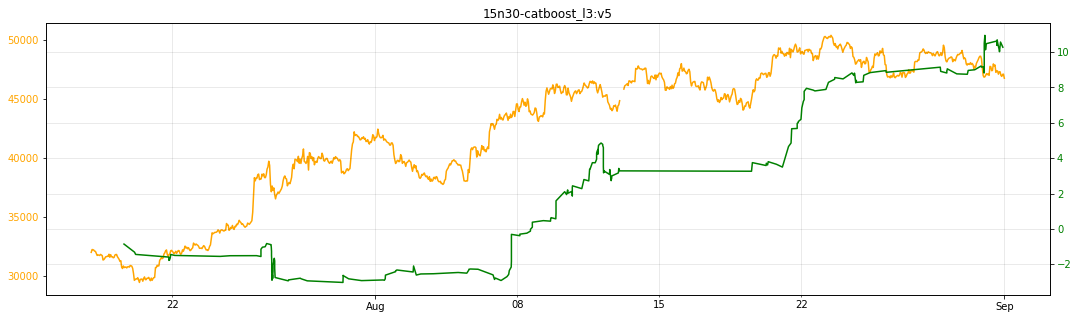

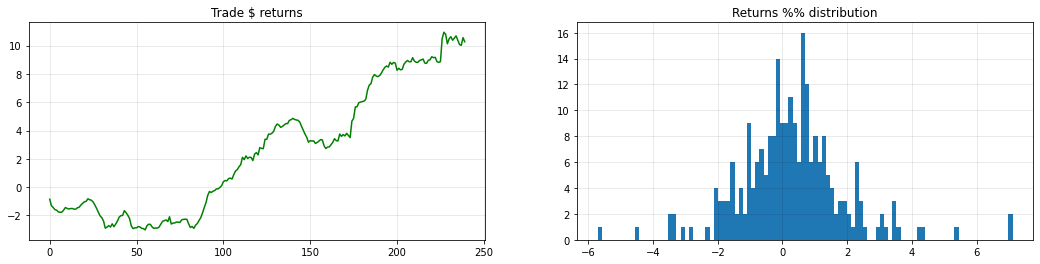

,Portfolio Summary
Trades,240
Avg. Stake Amount,15.0
Number of Pairs,45
Min Balance,-3.03
Max Balance,10.95
Final Balance,10.28
-,-
Wins,138
Loses,102
Win Rate,57.5%


INFO:freqtrade.nbtools.backtest:===============================
INFO:freqtrade.nbtools.backtest:|  'ml_test_15n30-catboost_l3__backtest-2021-09-05_17-14-08'
INFO:freqtrade.nbtools.backtest:|  WANDB LOG PRESET FINISHED  
INFO:freqtrade.nbtools.backtest:===============================


In [51]:
"""
This is a phase where you believe your strategy is now optimized along with your model.
This is not trial and error phase, and you can only run this phase ONCE every "good" optimized strategy to avoid biased results.
"""
stats, summary, preset = start_backtesting(opt_strategy, MODEL_NAME, "test", version=MODEL_VER)
trades = pd.DataFrame(stats["strategy"]["NotebookStrategy"]["trades"])
plotting.plot_profits_timerange(trades, timerange=preset.timerange, path_mount=PATH_MOUNT, name=fullname)